In [1]:

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt


In [2]:
# Set display options to show all columns and rows
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 1000)  # Set a large width value
pd.set_option('display.max_colwidth', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.min_rows', 20)  # Show at least 20 rows
pd.set_option('display.precision', 3)  # Set decimal precision
pd.set_option('display.float_format', lambda x: '%.3f' % x)  # Format floats
pd.set_option('display.colheader_justify', 'left')  # Left-align column headers

### Reading CSV files and creating a dictionary of dataframes by sensor_id

Checking data separately

In [3]:
import pandas as pd
import os
import matplotlib.pyplot as plt

In [4]:

# Directory path containing CSV files
csv_dir = 'csv_output_with_phases'

# Get list of all CSV files in directory
csv_files = [f for f in os.listdir(csv_dir) if f.endswith('.csv')]

csv_dict_by_sensor_id = {}

# Process each CSV file sequentially
for csv_file in csv_files:
    # Create file path
    file_path = os.path.join(csv_dir, csv_file)

    file_name = os.path.splitext(os.path.basename(file_path))[0].replace(' ', '_')
    
    sensor_id = file_name.split('_')[0] + '_' + file_name.split('_')[1] + '_' + file_name.split('_')[2]

    # Read CSV file
    df = pd.read_csv(file_path)
    df['sensor_id'] = sensor_id
    
    # convert time to datetime 
    df['time'] = pd.to_datetime(df['time'])
    
    # Calculate elapsed time in seconds from first timestamp
    df['elapsed_time'] = (df['time'] - df['time'].min()).dt.total_seconds()
    
    # Reorder columns to put sensor_id, time and elapsed_time first
    cols = ['sensor_id', 'time', 'elapsed_time'] + [col for col in df.columns if col not in ['sensor_id', 'time', 'elapsed_time']]
    df = df[cols]
    
    # Append dataframe to existing one if sensor_id exists, otherwise create new entry
    if sensor_id in csv_dict_by_sensor_id:
        csv_dict_by_sensor_id[sensor_id] = pd.concat([csv_dict_by_sensor_id[sensor_id], df[cols]], ignore_index=True) # use new indice
    else:
        csv_dict_by_sensor_id[sensor_id] = df[cols]


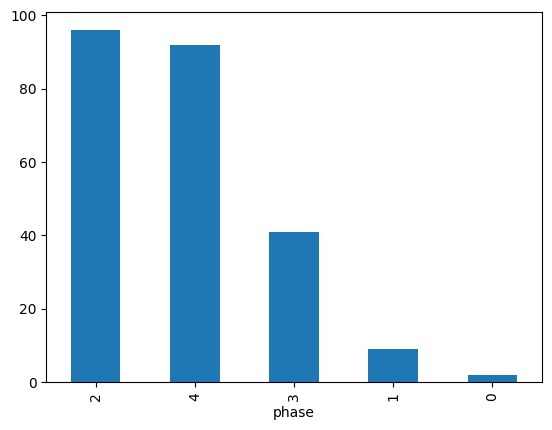

In [6]:
sensor_id = list(csv_dict_by_sensor_id.keys())[0]
df = csv_dict_by_sensor_id[sensor_id] 
df.phase.value_counts().plot(kind = 'bar')
plt.show()

In [7]:
# !pip install torch 
# !pip install torchvision
# !pip install torchaudio
# !pip install scikit-learn

---

## Base LSTM model experiment 
- Sensor data not normalized 
- Labels are not encoded 

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

#### Set up MPS 
[MPS](https://velog.io/@diduya/PyTorch-맥북-에어-M1칩에서-GPU-사용하기MPS-장치-활용-for-머신러닝-학습)

In [9]:
device = torch.device("mps")

#### preparing data 

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

original_class_names = ['heel strike', 'foot flat', 'heel off', 'toe off']
# Plot dataset Y distribution
dataset.y_df.value_counts().plot(kind='bar', ax=axes[0])
axes[0].set_xticks(range(len(original_class_names)))
axes[0].set_xticklabels(original_class_names, rotation=45)
axes[0].set_title('Dataset Y Distribution')

# Add legend with correct labels
handles, _ = axes[0].get_legend_handles_labels()
axes[0].legend(handles, [f"Class {i+1}" for i in range(len(original_class_names))], title="Classes")

lagged_class_names = ['no event', 'heel strike', 'foot flat', 'heel off', 'toe off']
# Plot data phase distribution
data['phase'].value_counts().plot(kind='bar', ax=axes[1])
axes[1].set_xticks(range(len(lagged_class_names)))
axes[1].set_xticklabels(lagged_class_names, rotation=45)
axes[1].set_title('Data Phase Distribution')

# Add legend with correct labels
handles, _ = axes[1].get_legend_handles_labels()
axes[1].legend(handles, [f"Phase {i}" for i in range(len(lagged_class_names))], title="Phases")

plt.tight_layout()
plt.show()


In [10]:
data_list = [ df[['gyroscope_x', 'gyroscope_y', 'gyroscope_z', 'accelerometer_x', 'accelerometer_y', 'accelerometer_z']] for df in csv_dict_by_sensor_id.values() ]
label_list = [ df['phase'] for df in csv_dict_by_sensor_id.values() ]

KeyError: 'phase'

In [ ]:
print("First 5 rows of features from first sensor:")
print(data_list[0].head())
print("\nFirst 5 labels from first sensor:")
print(label_list[0].head())
print("\nNumber of sensors (feature sequences):", len(data_list))
print("Number of sensors (label sequences):", len(label_list))


#### Creating windowed data set

In [ ]:
def create_sliding_windows(data, labels, window_size):
    windowed_data = []
    windowed_labels = []
    for start in range(0, len(data) - window_size + 1):
        window = torch.tensor(data[start:start + window_size].values, dtype=torch.float32)
        windowed_data.append(window)
        windowed_labels.append(labels.iloc[start + window_size - 1])
    return torch.stack(windowed_data), torch.tensor(windowed_labels)

data_sets = [] 
window_size = 5 # 50~ Experiment required 
for i in range(len(data_list)):
    windows, win_labels = create_sliding_windows(data_list[i], label_list[i], window_size)
    data_sets.append((windows, win_labels))

data_sets

#### Define a simple LSTM model

In [106]:
class GaitLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(GaitLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        out = self.fc(out)
        return out


#### Set up training parameters

In [126]:
input_size = 6  # feature size
hidden_size = 32
num_layers = 1
output_size = 5  # number of events

model = GaitLSTM(input_size, hidden_size, num_layers, output_size)
criterion = nn.CrossEntropyLoss()
SGD_optimizer = optim.SGD(model.parameters(), lr=0.001) #adam 

epochs = 8
batch_size = 30

#### Train model

In [ ]:
# Check if MPS is available, otherwise use CPU
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# Move model and criterion to device before training loop
model.to(device)
criterion.to(device)

train_loss_history = [] # loss
train_acc_history = [] # accuracy

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for idx, (windows, win_labels) in enumerate(data_sets):
        # Create dataset and dataloader
        dataset = torch.utils.data.TensorDataset(
            windows.to(device), 
            win_labels.to(device)
        )
        
        data_loader = DataLoader(
            dataset=dataset,
            batch_size=batch_size,
            shuffle=False,
            num_workers = os.cpu_count() if not torch.backends.mps.is_available() else 0   # Set to 0 when using MPS
        )
        
        for batch_idx, (inputs, labels) in enumerate(data_loader):
            SGD_optimizer.zero_grad()
            
            outputs = model(inputs)  # inputs already on device from dataset
            loss = criterion(outputs, labels)  # labels already on device from dataset
            loss.backward()
            
            SGD_optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        if idx % 10 == 9: # print every 100 batches
            avg_loss = running_loss / 100
            accuracy = correct / total
            print(f"[Epoch {epoch+1}, Iteration {idx+1}] loss: {avg_loss:.3f} acc: {accuracy:.2%}")
            train_loss_history.append(avg_loss)
            train_acc_history.append(accuracy)
            running_loss = 0.0
            correct = 0
            total = 0

In [ ]:
with torch.no_grad():
    model.eval()
    test_loss = 0.0
    test_correct = 0
    test_total = 0

    for idx, (windows, win_labels) in enumerate(data_sets):
        dataset = torch.utils.data.TensorDataset(
            windows.to(device), 
            win_labels.to(device)
        )

        data_loader = torch.utils.data.DataLoader(
            dataset=dataset,
            batch_size=batch_size,
            shuffle=False,
            num_workers = os.cpu_count() if not torch.backends.mps.is_available() else 0   # Set to 0 when using MPS
        )
        
        for batch_idx, (inputs, labels) in enumerate(data_loader):
            outputs = model(inputs)  # inputs already on device from dataset
            loss = criterion(outputs, labels)  # labels already on device from dataset
            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            test_correct += (predicted == labels).sum().item()
            test_total += labels.size(0)

        if idx % 10 == 9:  # print every 10 batches
            avg_test_loss = test_loss / test_total
            test_accuracy = test_correct / test_total
            print(f"[Test Batch {idx+1}] loss: {avg_test_loss:.3f} acc: {test_accuracy:.2%}")